## Set up env

In [1]:
#!virtualenv -p C:/Python39 --distribute temp-python

In [2]:
#%pip install --user torch==1.10.2

In [3]:
#!pip list --local

In [4]:
#!pip install monai

In [5]:
#!pip install -r G:/pkgs.txt

In [6]:
import setuptools
import torch
import numpy as np
import h5py
from tqdm import tqdm
import time

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.metrics import compute_meandice

from scipy.ndimage import distance_transform_edt as distance
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

In [7]:
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    RandSpatialCropd,
    CropForegroundd,
    CenterSpatialCropd,
    NormalizeIntensityd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm_gui

## Download data

In [8]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\ADMINI~1.WIN\AppData\Local\Temp\tmpf75wxivy


In [11]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar"


compressed_file = os.path.join(root_dir, "Task02_Heart.tar")
tempPath="G:\molloi-lab\project-distance-transforms"
#data_dir = os.path.join(root_dir, "Task02_Heart")
data_dir = os.path.join(tempPath, "Task02_Heart")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

## Set up datasets

In [12]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [13]:
set_determinism(seed=0)

In [14]:
image_size = (96, 96, 96)

In [15]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
     ]
 )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
    ]
)

In [16]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

## Visualize dataset

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


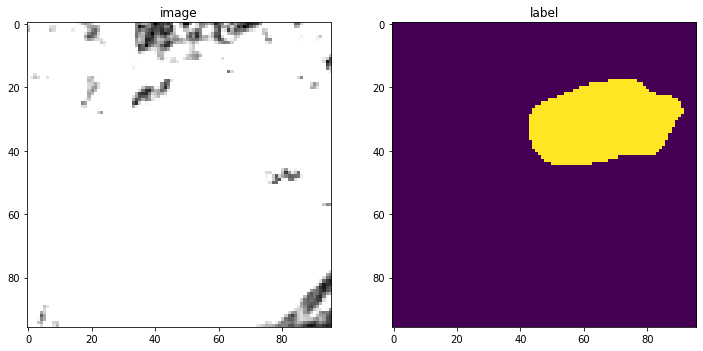

torch.Size([1, 1, 96, 96, 96])


In [17]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 40], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 60])
plt.show()
print(check_data['label'].shape)

## Set up loss functions

In [18]:
def dice_loss(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss

In [19]:
def compute_dtm(img_gt, out_shape):
    """
    compute the distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the foreground Distance Map (SDM) 
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    fg_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
        for c in range(1, out_shape[1]):
            posmask = img_gt[b].astype(np.bool)
            if posmask.any():
                posdis = distance(posmask)
                fg_dtm[b][c] = posdis

    return fg_dtm

In [20]:
def hd_loss(seg_soft, gt, seg_dtm, gt_dtm):
    """
    compute huasdorff distance loss for binary segmentation
    input: seg_soft: softmax results,  shape=(b,2,x,y,z)
           gt: ground truth, shape=(b,x,y,z)
           seg_dtm: segmentation distance transform map; shape=(b,2,x,y,z)
           gt_dtm: ground truth distance transform map; shape=(b,2,x,y,z)
    output: boundary_loss; sclar
    """

    delta_s = (seg_soft[:,1,...] - gt.float()[:,0,...]) ** 2
    s_dtm = seg_dtm[:,1,...] ** 2
    g_dtm = gt_dtm[:,1,...] ** 2
    dtm = s_dtm + g_dtm
    multipled = torch.einsum('bxyz, bxyz->bxyz', delta_s, dtm)
    hd_loss = multipled.mean()

    return hd_loss

## Set up dataloader

In [21]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
     cache_rate=1.0, num_workers=4)
#train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
  data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


## Train

In [22]:
device = torch.device("cuda:0")
net = monai.networks.nets.BasicUNet().to(device)

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [23]:
base_lr = 0.001
max_iterations = 20000

In [25]:
optimizer = torch.optim.Adam(net.parameters(), lr=base_lr, weight_decay=0.0001)

In [26]:
iter_num = 0
alpha = 1.0

lr_ = base_lr

In [27]:
max_epochs = 60
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_epoch_loss = []
metric_values = []
time_list_epoch = []
time_list_batch = []
metric_count = 0
metric_sum = 0.0
new_loss = 0
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

In [28]:
time.time()

1648957718.780473

In [29]:
for epoch_num in range(max_epochs):
    time_list_epoch.append(time.time())
    print("-" * 10)
    print(f"epoch {epoch_num + 1}/{max_epochs}")
    net.train()
    epoch_loss = 0
    step = 0
    for i_batch, sampled_batch in enumerate(train_loader):
        time_list_batch.append(time.time())
        step +=1
        # print('fetch data cost {}'.format(time2-time1))
        # volume_batch.shape=(b,1,x,y,z) label_patch.shape=(b,x,y,z)
        volume_batch, label_batch = sampled_batch['image'].cuda(), sampled_batch['label'].cuda()
        outputs = net(volume_batch)
        outputs, label_batch = outputs.type(torch.Tensor), label_batch.type(torch.Tensor)

        loss_seg = 0
        # for i in range(outputs.size()[2]):
        #     # print(outputs[:, :, i].shape, "\n", label_batch[:, i].shape)
        #     loss_seg += F.cross_entropy(outputs[:, :, i], label_batch[:, i])

        outputs_soft = F.softmax(outputs, dim=1)
        loss_seg_dice = dice_loss(outputs_soft[:, 1, :, :, :], label_batch == 1)
        # compute distance maps and hd loss
        with torch.no_grad():
            # defalut using compute_dtm; however, compute_dtm01 is also worth to try;
            gt_dtm_npy = compute_dtm(label_batch.cpu().numpy(), outputs_soft.shape)
            gt_dtm = torch.from_numpy(gt_dtm_npy).float().cuda(outputs_soft.device.index)
            seg_dtm_npy = compute_dtm(outputs_soft[:, 1, :, :, :].cpu().numpy()>0.5, outputs_soft.shape)
            seg_dtm = torch.from_numpy(seg_dtm_npy).float().cuda(outputs_soft.device.index)

            

        loss_hd = hd_loss(outputs_soft.cpu(), label_batch.cpu(), seg_dtm.cpu(), gt_dtm.cpu())
        loss = alpha*(loss_seg+loss_seg_dice) + (1 - alpha) * loss_hd
        y_pred = post_pred(outputs)
        y = post_label(label_batch)

        accu = compute_meandice(
                    y_pred=y_pred,
                    y=y,
                    include_background=False,
                )
        acc = accu.sum().item()/len(accu)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss:.4f},"
            f"acc: {acc:.4f}")


        iter_num = iter_num + 1

        ## change lr
        if iter_num % 2500 == 0:
            lr_ = base_lr * 0.1 ** (iter_num // 2500)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
        if iter_num % 1000 == 0:
            save_mode_path = os.path.join(snapshot_path, 'iter_' + str(iter_num) + '.pth')
            torch.save(net.state_dict(), save_mode_path)
            logging.info("save model to {}".format(save_mode_path))

        if iter_num > max_iterations:
            break
        time1 = time.time()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch_num + 1} average loss: {epoch_loss:.4f}")
    alpha -= 0.001
    if alpha <= 0.001:
        alpha = 0.001
    if iter_num > max_iterations:
        break


    if (epoch_num + 1) % val_interval == 0:
        new_loss = 0
        net.eval()
        val_step = 0
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            val_step +=1
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].cuda(),
                    val_data["label"].cuda()
                )
                roi_size = (96,96,96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, net)
                val_outputs, val_labels = val_outputs.type(torch.Tensor), val_labels.type(torch.Tensor)
                loss_seg = 0
                outputs_soft = F.softmax(val_outputs, dim=1)
                loss_seg_dice = dice_loss(outputs_soft[:, 1, :, :, :], val_labels == 1)
                # compute distance maps and hd loss
                with torch.no_grad():
                # defalut using compute_dtm; however, compute_dtm01 is also worth to try;
                    gt_dtm_npy = compute_dtm(val_labels.cpu().numpy(), outputs_soft.shape)
                    gt_dtm = torch.from_numpy(gt_dtm_npy).float().cuda(outputs_soft.device.index)
                    seg_dtm_npy = compute_dtm(outputs_soft[:, 1, :, :, :].cpu().numpy()>0.5, outputs_soft.shape)
                    seg_dtm = torch.from_numpy(seg_dtm_npy).float().cuda(outputs_soft.device.index)

            

                loss_hd = hd_loss(outputs_soft.cpu(), val_labels.cpu(), seg_dtm.cpu(), gt_dtm.cpu())
                val_loss = alpha*(loss_seg+loss_seg_dice) + (1 - alpha) * loss_hd
                new_loss+= val_loss.item()

                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            new_loss /= val_step
            val_epoch_loss.append(new_loss)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch_num + 1
                torch.save(net.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch_num + 1} current mean dice: {metric:.4f} current Val Loss: {val_loss.item():.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/60


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1/11, train_loss: 0.8545,acc: 0.0978
2/11, train_loss: 0.7694,acc: 0.1840
3/11, train_loss: 0.8417,acc: 0.1177
4/11, train_loss: 0.7375,acc: 0.2161
5/11, train_loss: 0.7098,acc: 0.2640
6/11, train_loss: 0.8946,acc: 0.0325
7/11, train_loss: 0.7185,acc: 0.2381
8/11, train_loss: 0.7076,acc: 0.3075
9/11, train_loss: 0.5679,acc: 0.4578
10/11, train_loss: 0.6152,acc: 0.4134
11/11, train_loss: 0.6994,acc: 0.3384
epoch 1 average loss: 0.7378
----------
epoch 2/60
1/11, train_loss: 0.6904,acc: 0.3876
2/11, train_loss: 0.6234,acc: 0.4924
3/11, train_loss: 0.5561,acc: 0.6180
4/11, train_loss: 0.7077,acc: 0.3330
5/11, train_loss: 0.4640,acc: 0.6499
6/11, train_loss: 0.5250,acc: 0.5607
7/11, train_loss: 0.5197,acc: 0.5520
8/11, train_loss: 0.4908,acc: 0.5796
9/11, train_loss: 0.3474,acc: 0.7811
10/11, train_loss: 0.5049,acc: 0.5753
11/11, train_loss: 0.3934,acc: 0.6963
epoch 2 average loss: 0.5294
saved new best metric model
current epoch: 2 current mean dice: 0.5789 current Val Loss: 0.4563
best m

Task02_Heart.tar:  31%|███       | 133M/435M [11:45<26:39, 198kB/s]

1/11, train_loss: 0.1101,acc: 0.8575


2/11, train_loss: 0.0946,acc: 0.8709
3/11, train_loss: 0.1147,acc: 0.8532
4/11, train_loss: 0.1097,acc: 0.8608
5/11, train_loss: 0.1708,acc: 0.7905
6/11, train_loss: 0.0975,acc: 0.8745
7/11, train_loss: 0.1263,acc: 0.8378
8/11, train_loss: 0.1000,acc: 0.8711
9/11, train_loss: 0.0884,acc: 0.8851
10/11, train_loss: 0.1348,acc: 0.8327
11/11, train_loss: 0.1257,acc: 0.8446
epoch 28 average loss: 0.1157
current epoch: 28 current mean dice: 0.7421 current Val Loss: 0.1288
best mean dice: 0.7768 at epoch: 26
----------
epoch 29/60
1/11, train_loss: 0.1027,acc: 0.8702
2/11, train_loss: 0.1243,acc: 0.8410
3/11, train_loss: 0.1650,acc: 0.7953
4/11, train_loss: 0.0986,acc: 0.8752
5/11, train_loss: 0.1434,acc: 0.8196
6/11, train_loss: 0.1292,acc: 0.8403
7/11, train_loss: 0.0944,acc: 0.8780
8/11, train_loss: 0.1447,acc: 0.8187
9/11, train_loss: 0.1148,acc: 0.8496
10/11, train_loss: 0.1043,acc: 0.8647
11/11, train_loss: 0.1327,acc: 0.8333
epoch 29 average loss: 0.1231
----------
epoch 30/60
1/11, tr

In [30]:
value

tensor([[0.8231]])

In [31]:
len(val_epoch_loss)

30

In [32]:
a = np.array(time_list_epoch)
delta_time_epoch = np.diff(a)

In [33]:
b = np.array(time_list_batch)
delta_time_step = np.diff(b)

In [34]:
avg_step_time = np.mean(delta_time_step)
avg_step_time # should be about ~2 seconds per step

1.622439032078513

In [35]:
avg_epoch_time = np.mean(delta_time_epoch)
avg_epoch_time # should be about ~20 seconds per epoch

18.00405436451152

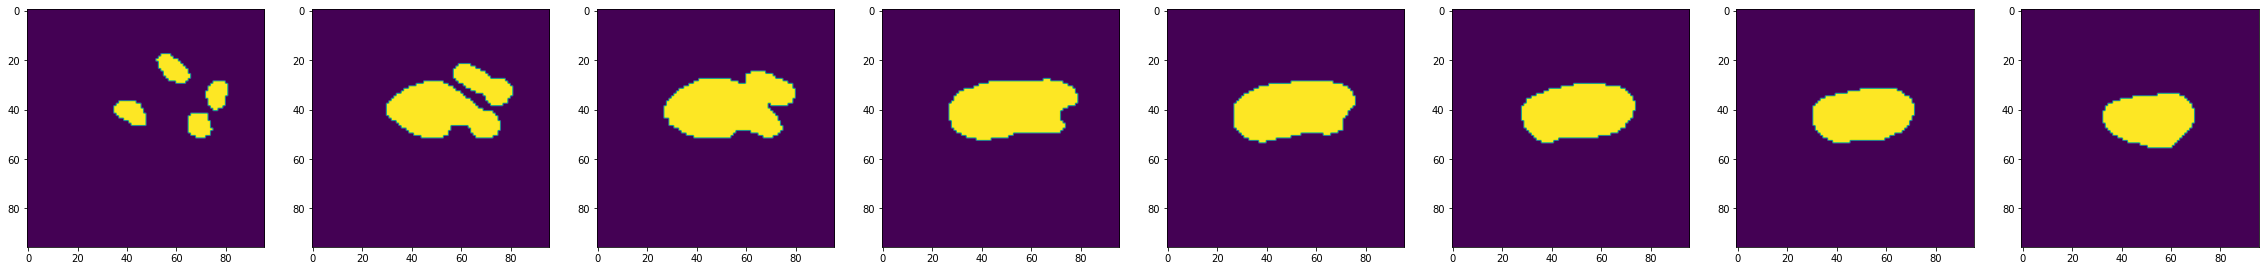

In [36]:
plt.figure("Train", (40, 20))
plt.subplot(1, 8, 1)
plt.imshow(label_batch[0,0,...,30])
plt.subplot(1, 8, 2)
plt.imshow(label_batch[0,0,...,35])
plt.subplot(1, 8, 3)
plt.imshow(label_batch[0,0,...,40])
plt.subplot(1, 8, 4)
plt.imshow(label_batch[0,0,...,45])
plt.subplot(1, 8, 5)
plt.imshow(label_batch[0,0,...,50])
plt.subplot(1, 8, 6)
plt.imshow(label_batch[0,0,...,55])
plt.subplot(1, 8, 7)
plt.imshow(label_batch[0,0,...,60])
plt.subplot(1, 8, 8)
plt.imshow(label_batch[0,0,...,65])

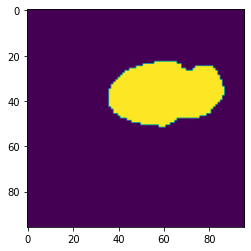

In [37]:
plt.imshow(val_outputs.detach().numpy()[0,1,...,40])

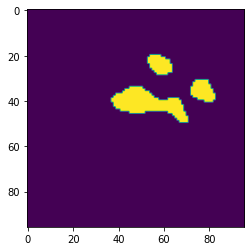

In [38]:
plt.imshow(y_pred[0,1,...,30])

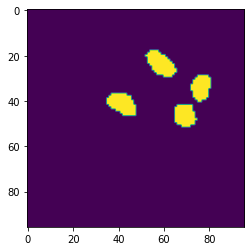

In [39]:
plt.imshow(label_batch[0,0,...,30])

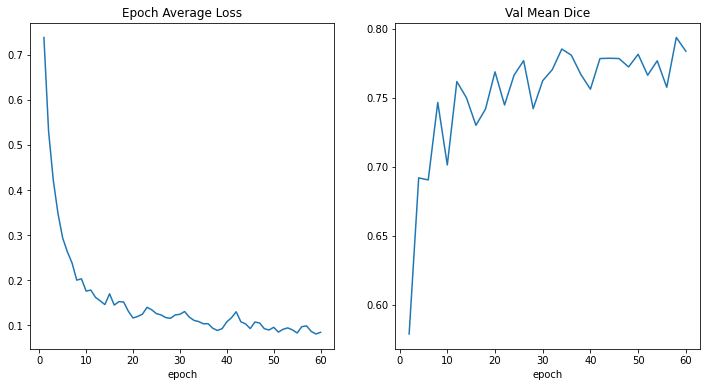

In [40]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

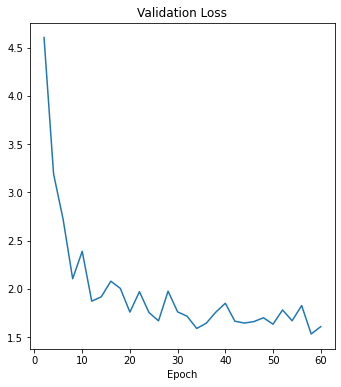

In [41]:
plt.figure("Validation", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Validation Loss")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = val_epoch_loss
plt.xlabel("Epoch")
plt.plot(x, y)
plt.show()

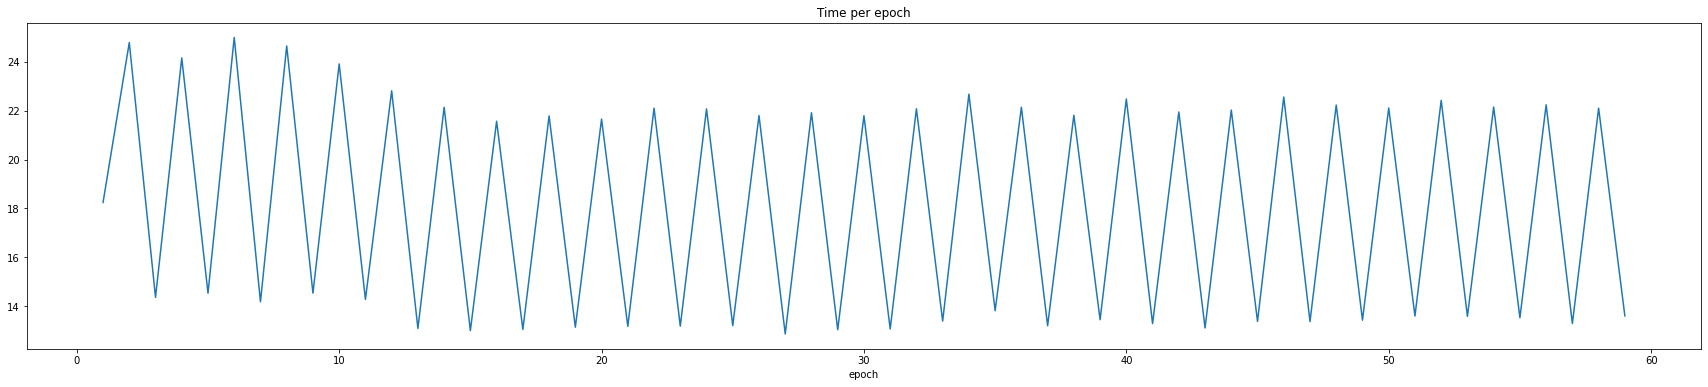

In [42]:
plt.figure("Time", (30, 6))
plt.title("Time per epoch")
x = [i + 1 for i in range(len(a)-1)]
y = [a[i+1]-a[i] for i in range(len(a)-1)]
plt.xlabel("epoch")
plt.plot(x, y)


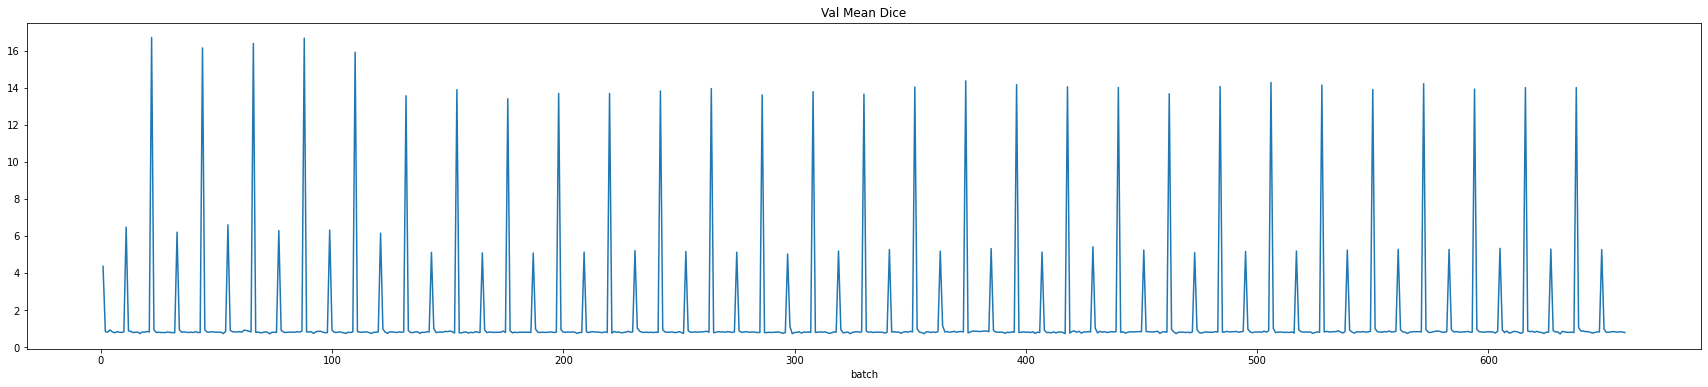

In [43]:
plt.figure("Time", (30, 6))
plt.title("Val Mean Dice")
x = [i + 1 for i in range(len(b)-1)]
y = [b[i+1]-b[i] for i in range(len(b)-1)]
plt.xlabel("batch")
plt.plot(x, y)
plt.show()

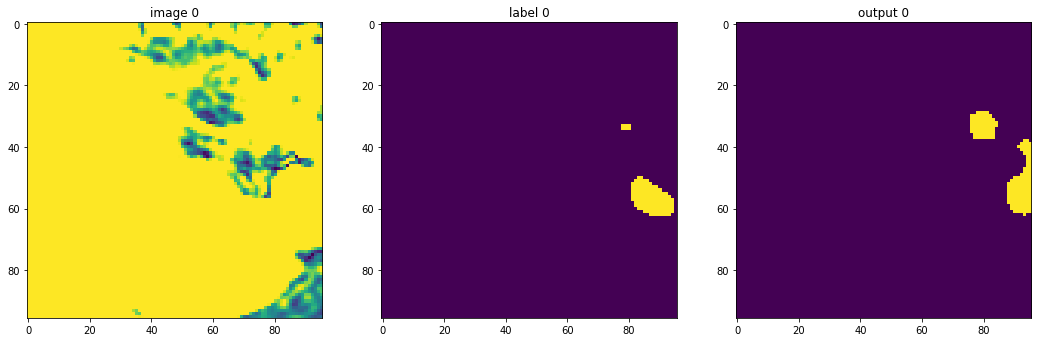

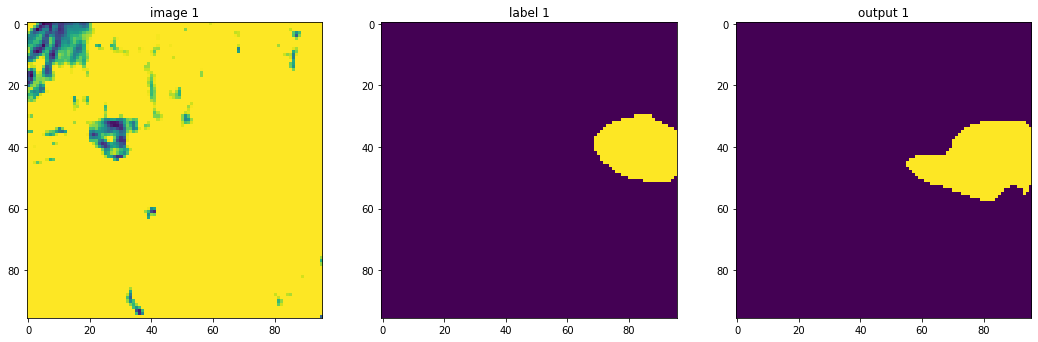

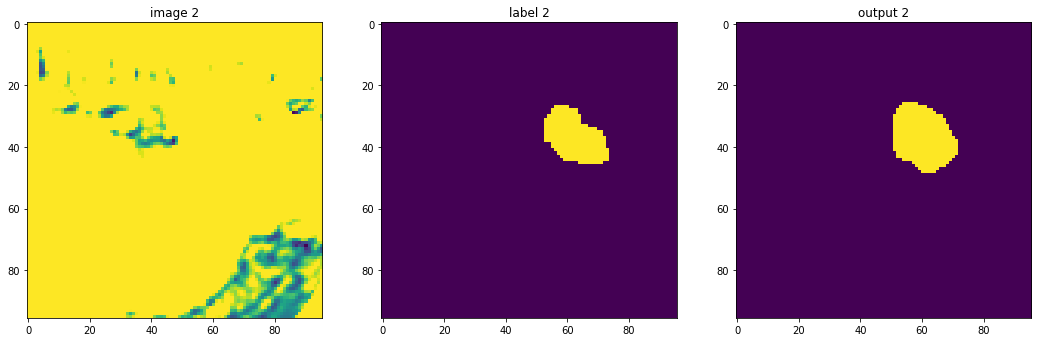

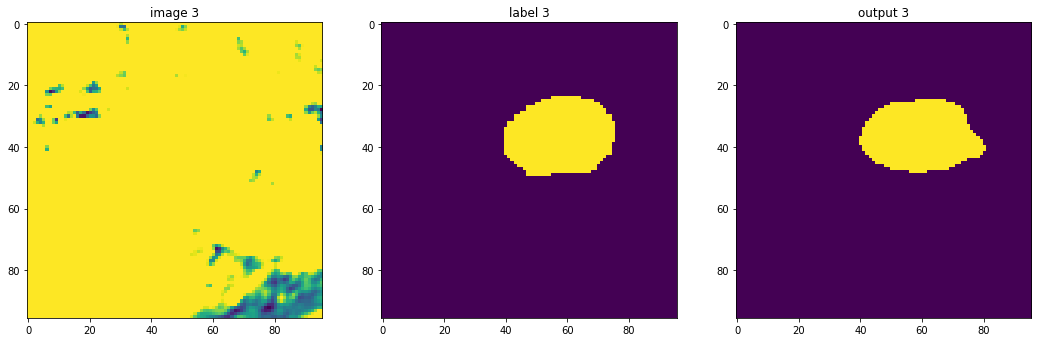

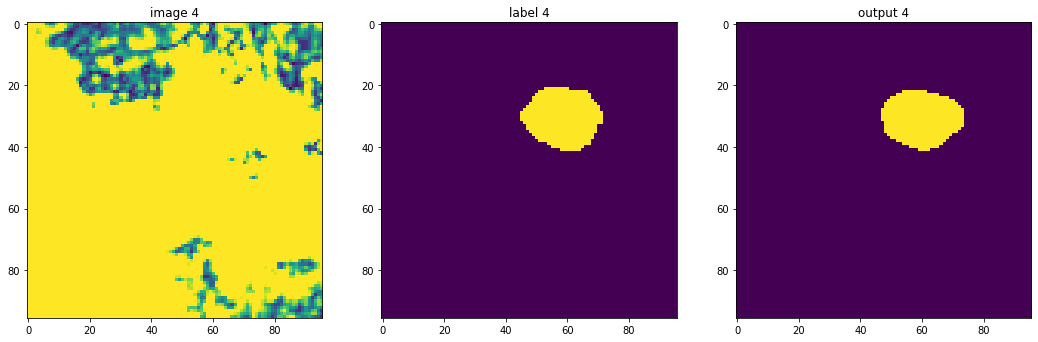

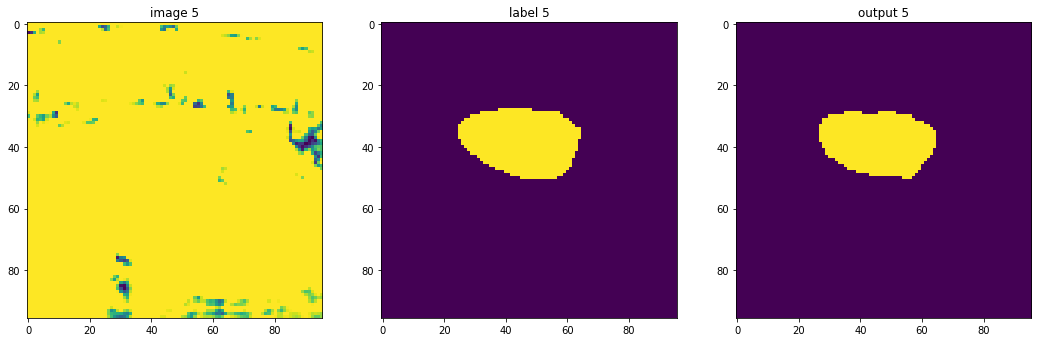

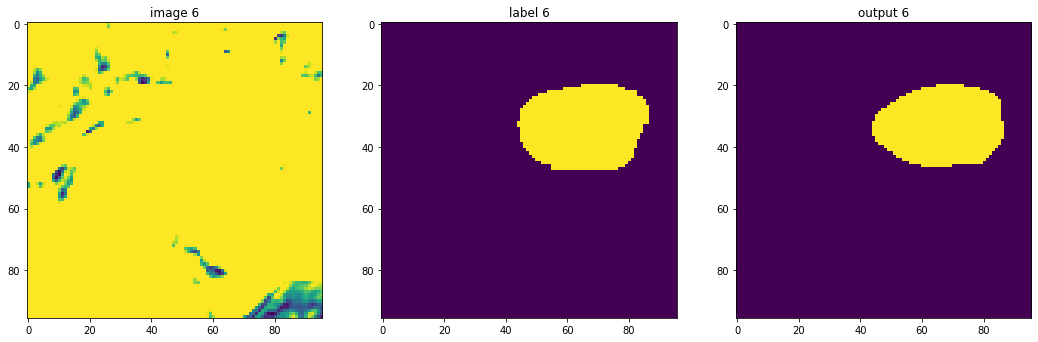

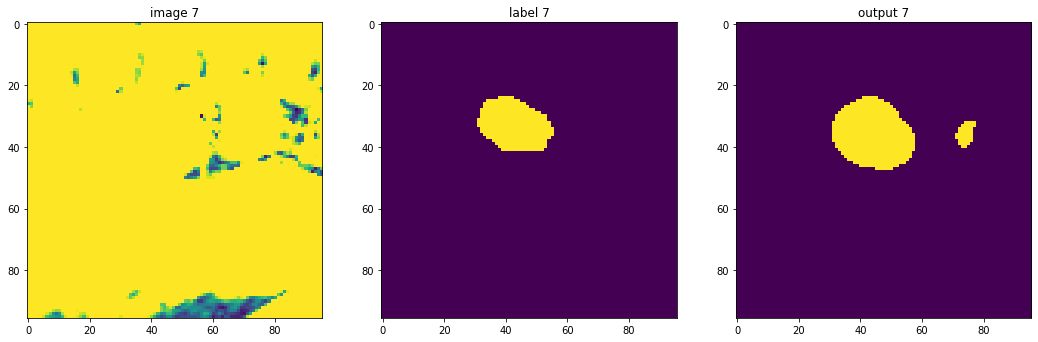

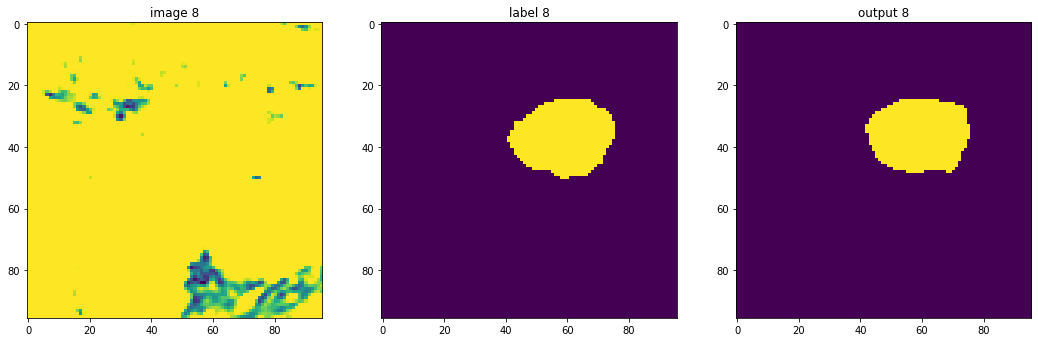

In [44]:
net.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), (roi_size), sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 70])
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 70])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(post_pred(val_outputs).detach().cpu()[0,1,..., 70])
        plt.show()